# TD3 电磁式阻尼器振动控制训练

本notebook用于训练基于GRU网络架构的TD3算法，用于电磁式阻尼器的振动控制，

## 主要特点
- 使用TD3（Twin Delayed Deep Deterministic Policy Gradient）算法
- 可以输入时间序列
- 针对电磁式阻尼器系统的振动控制优化

### 训练参数

In [1]:
# 参数设置
train_model = True  # 是否训练模型
reset = False  # 是否重置训练轮次
freeze_gru = False  # 是否冻结预测器的GRU层

# 环境参数
ENV_PARAMS = {
    'Ts': 0.001,  # 采样时间
    'T': 1.0,    # 仿真时长
    'state0':[0.0, 0.0, 0.0, 0.0, 1, 0.0], # 初始状态
    # 观测状态列表
    # 0: 吸振器位移 (x1)
    # 1: 吸振器速度 (v1)
    # 2: 吸振器加速度 (a1)
    # 3: 平台位移 (x2)
    # 4: 平台速度 (v2)
    # 5: 平台加速度 (a2)
    'observation_indices': [0,1,2,3,4,5],  # 观测状态索引
    'x1_limit': 10000,      # x1 位移限制
    'use_dt_noise': False,    # 使用时间步长噪声
    'dt_noise_std': 0.1       # 时间步长噪声标准差
}

# TD3参数
TD3_PARAMS = {
    'norm': False,               # 是否归一化
    'simple_nn': False,        # 是否使用简单的全连接网络
    'state_dim': len(ENV_PARAMS['observation_indices']),  # 观测维度（平台位移）
    'mlp_hidden_dim': 128,          # mlp隐藏层维度
    'gru_hidden_dim': 64,       # gru隐藏层维度
    'action_bound': 5.0,        # 动作范围
    
    'actor_lr': 2e-06,           # Actor学习率
    'critic_lr': 1e-05,          # Critic学习率
    'gru_predictor_lr': 3e-04,   # 预测器学习率
    'gamma': 0.99,              # 折扣因子
    'tau': 0.001,               # 软更新参数
    
    'policy_noise': 0.2,        # 策略噪声
    'noise_clip': 0.5,          # 噪声裁剪
    'policy_freq': 3,           # 策略更新频率
    'action_sigma': 0.15,       # 选择动作时的最大噪声
    'rand_prob': 0,             # 随机动作概率
    'clip_grad': 1,          # 是否裁剪梯度
    'seq_len' : 36,            # GRU序列长度
    'fc_seq_len': 4,           # 预测时间步长度
    'gru_layers': 1,            # GRU层数
    'aware_dt': False,          # 是否感知时间步长
    'aware_delay_time': True,   # 是否感知动作延迟时间
    'delay_enabled': True,      # 是否启用动作延迟
    'delay_step': 2,            # 动作延迟步数均值
    'delay_sigma': 0            # 动作延迟步数标准差
}

# 训练参数
TRAIN_PARAMS = {
    'tolerance': 0.001,          # 容忍度
    'n_episodes': 1000,           # 训练轮次
    'capacity': int(5e5),       # 经验回放池容量
    'min_buffer_size': int(5e3),# 最小缓冲区大小
    'print_interval': 5,        # 打印间隔
    'save_interval': 5,         # 保存间隔
    'batch_size': 256,         # 批次大小
    }

### 仿真环境搭建

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
from datetime import datetime
import os

# 导入自定义模块
from TD3 import Gru_TD3Agent
from nn import Gru_ReplayBuffer
from env import ElectromagneticDamperEnv
from train import train_td3
from af import Datasets, STATES_NAME, plot_compare_no_control, plot_data

# 设置中文字体和GPU
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 检查GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 设置随机种子
# np.random.seed(42)
# torch.manual_seed(42)
print(f"使用设备: {device}")

使用设备: cuda


In [3]:
# 日志文件
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
# 创建保存模型的基础目录
base_dir = ".\\savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认项目文件夹
project_name = input("请输入加载/创建项目的名称 (父目录: .\\savedata) ").strip()
project_path = os.path.join(base_dir, project_name)

# 检查项目文件夹是否存在
is_new_project = not os.path.exists(project_path)
os.makedirs(project_path, exist_ok=True)

# 创建检查点保存目录
save_checkpoint_path = os.path.join(project_path, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)

# 创建绘图保存目录
save_plot_path = os.path.join(project_path, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = os.path.join(project_path, f'training_log_{current_time}.log')
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = os.path.join(project_path, f'training_log_{current_time}.log')

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", project_path)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)
logging.info("环境参数: %s", ENV_PARAMS)
logging.info("算法参数: %s", TD3_PARAMS)
logging.info("训练参数: %s", TRAIN_PARAMS)
print(f"日志文件: {file_path}")

日志文件: .\savedata\1201感知延迟训练（初速度初始-2时间步）探索增强\training_log_20251201_193816.log


In [4]:
# 系统参数
m = 1.0    # 电磁吸振器质量
M = 15  # 待减振对象质量
k_m = 30_000  # 电磁吸振器刚度
k_M = 300_000  # 平台刚度
k_f = 100 # * TD3_PARAMS['action_bound']  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 0.1 # 1.0  # 电磁吸振器阻尼
c_M = 1 # 5.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[+k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

F = np.array([[0.0], [0.0], [0.0], [1/M]]) # 直接扰动力的输入矩阵

logging.info("系统参数: m=%.2f, M=%.2f, k_m=%.2f, k_M=%.2f, k_f=%.2f, k_E=%.2f, L=%.4f, R_m=%.2f, c_m=%.2f, c_M=%.2f", 
             m, M, k_m, k_M, k_f, k_E, L, R_m, c_m, c_M)

In [5]:
# 定义扰动函数和奖励函数
import inspect

from fx import zero, sin_wave
z_func = zero
# z_func = sin_wave(amplitude=0.005, frequency=30, phase=0)
from fx import tolerance_if_rf, simple_reward,smooth_reward
r_func = tolerance_if_rf(tolerance=TRAIN_PARAMS['tolerance'])
# r_func = smooth_reward(tolerance=TRAIN_PARAMS['tolerance'])
# r_func = simple_reward(tolerance=TRAIN_PARAMS['tolerance'])
f_func = sin_wave(amplitude=300, frequency=40, phase=0)
f_func = zero

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))
if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))
if train_model: logging.info("外部扰动函数已定义: %s", inspect.getsource(f_func))

In [6]:
# 初始化环境
env = ElectromagneticDamperEnv(
    A=A, B=B, C=C, D=D, E=E,F=F,
    Ts=ENV_PARAMS['Ts'],  # 采样时间
    T=ENV_PARAMS['T'],    # 仿真时长
    z_func=z_func,
    r_func=r_func,
    f_func=f_func,
    state0=np.array(ENV_PARAMS['state0']),  # 初始状态
    obs_indices=ENV_PARAMS['observation_indices'],  # 观测状态索引
    x1_limit=ENV_PARAMS['x1_limit'],  # x1 位移限制
    use_dt_noise=ENV_PARAMS['use_dt_noise'], # 是否使用时间步长噪声
    dt_noise_std=ENV_PARAMS['dt_noise_std'], # 时间步长噪声标准差
    tolerance=TRAIN_PARAMS['tolerance']  # 容忍度
)

logging.info("环境初始化完成，观测维度: %s", [STATES_NAME[idx] for idx in ENV_PARAMS['observation_indices']])
print(f"环境初始化完成，观测维度: {[STATES_NAME[idx] for idx in ENV_PARAMS['observation_indices']]}")

环境初始化完成，观测维度: ['吸振器位移 (x1)', '吸振器速度 (v1)', '吸振器加速度 (a1)', '平台位移 (x2)', '平台速度 (v2)', '平台加速度 (a2)']


仿真进度: 100%|██████████| 1000/1000 [00:00<00:00, 7131.79it/s]


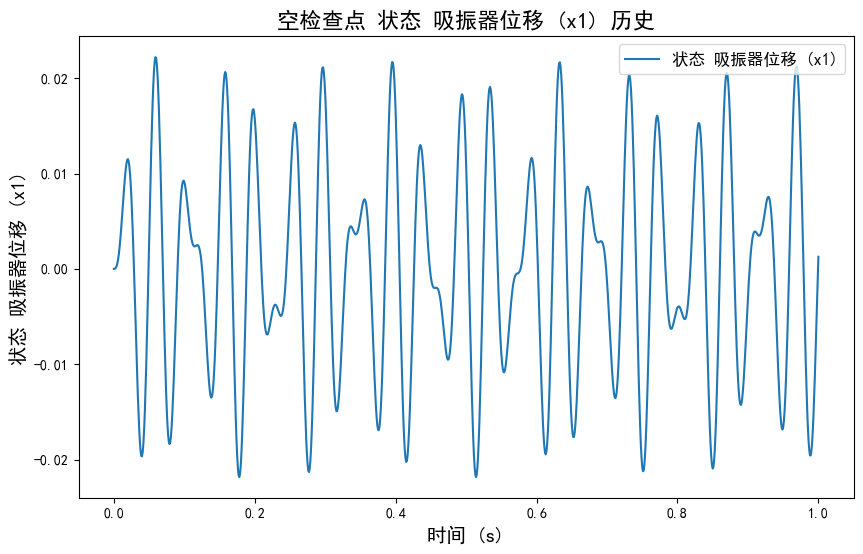

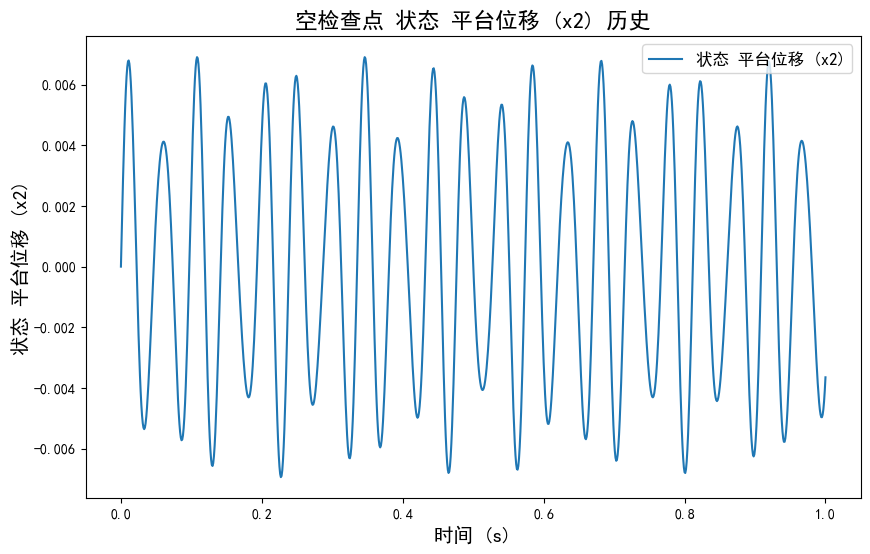

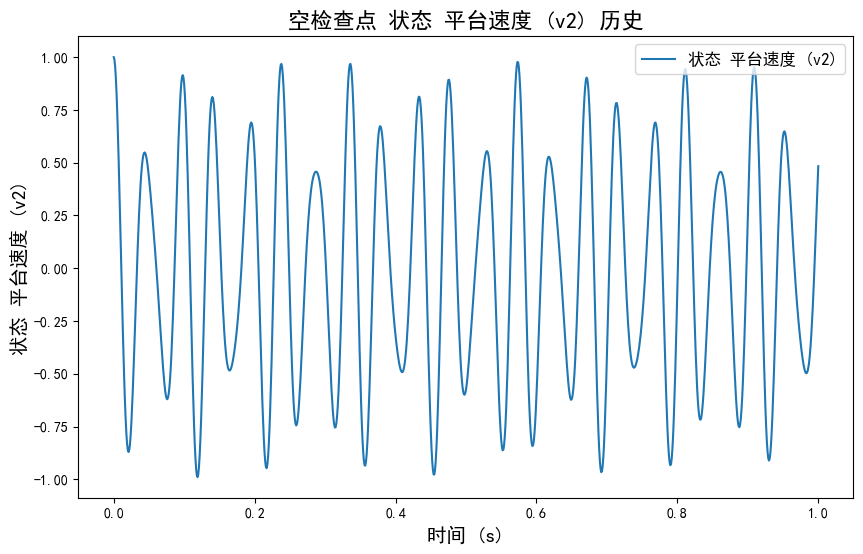

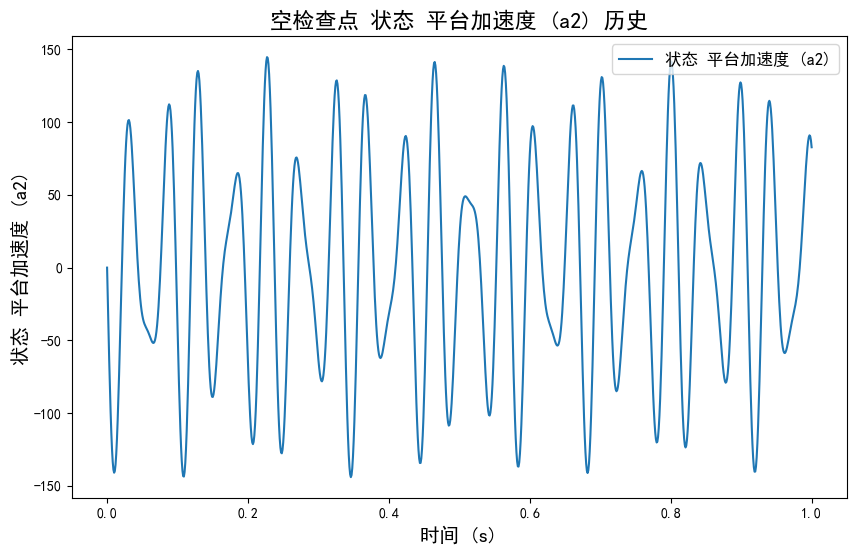

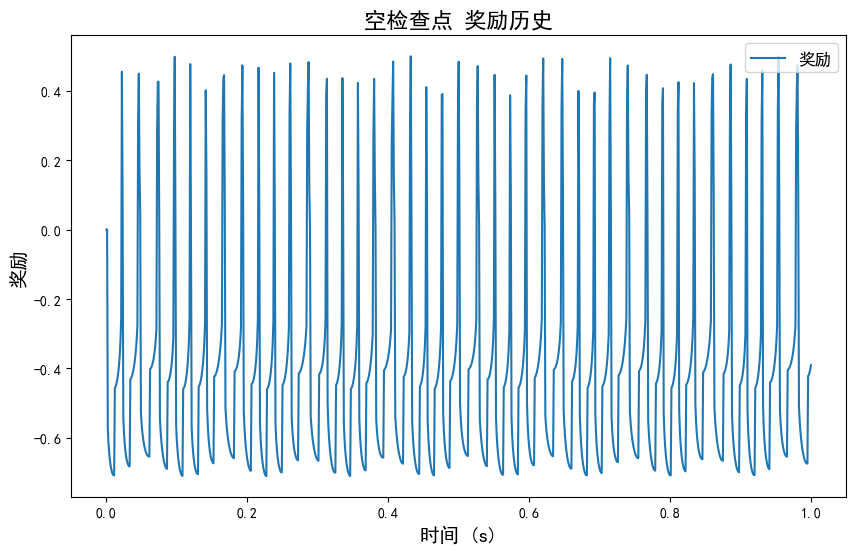

In [7]:
# 环境测试
test_datasets = env.run_simulation()
# 通过差分验证环境正常
# plot_data(x_values_list=test_datasets.time_history, y_values_list=test_datasets.state_history[:, 0], 
#                           plot_title=f'{test_datasets.checkpoint_name} 状态 {STATES_NAME[0]} 历史', legends=[f'状态 {STATES_NAME[0]}'], 
#                           xlabel='时间 (s)', ylabel=f'状态 {STATES_NAME[0]}', show=True)
# plot_data(x_values_list=test_datasets.time_history[1:], y_values_list=(test_datasets.state_history[1:, 0]-test_datasets.state_history[:-1, 0])/env.Ts, 
#                           plot_title=f'{test_datasets.checkpoint_name} 状态 {STATES_NAME[1]} 历史', legends=[f'状态 {STATES_NAME[1]}'], 
#                           xlabel='时间 (s)', ylabel=f'状态 {STATES_NAME[1]}', show=True)
# plot_data(x_values_list=test_datasets.time_history, y_values_list=test_datasets.state_history[:, 1], 
#                           plot_title=f'{test_datasets.checkpoint_name} 状态 {STATES_NAME[1]} 历史', legends=[f'状态 {STATES_NAME[1]}'], 
#                           xlabel='时间 (s)', ylabel=f'状态 {STATES_NAME[1]}', show=True)
# plot_data(x_values_list=test_datasets.time_history, y_values_list=test_datasets.state_history[:, 2], 
#                           plot_title=f'{test_datasets.checkpoint_name} 状态 {STATES_NAME[2]} 历史', legends=[f'状态 {STATES_NAME[2]}'], 
#                           xlabel='时间 (s)', ylabel=f'状态 {STATES_NAME[2]}', show=True)
# plot_data(x_values_list=test_datasets.time_history[1:], y_values_list=(test_datasets.state_history[1:, 1]-test_datasets.state_history[:-1, 1])/env.Ts, 
#                           plot_title=f'{test_datasets.checkpoint_name} 状态 {STATES_NAME[1]} 历史', legends=[f'状态 {STATES_NAME[1]}'], 
#                           xlabel='时间 (s)', ylabel=f'状态 {STATES_NAME[1]}', show=True)
test_datasets.plot_episode_history(plot_state=[0, 3, 4, 5], plot_reward=True, plot_dt=TD3_PARAMS['aware_dt'], save_path=save_plot_path, show=True)

In [8]:
# 初始化GRU-TD3代理
agent = Gru_TD3Agent(
    norm=TD3_PARAMS['norm'],
    simple_nn=TD3_PARAMS['simple_nn'],
    freeze_gru=freeze_gru,
    
    state_dim=len(ENV_PARAMS['observation_indices']) + int(TD3_PARAMS['aware_dt']) + int(TD3_PARAMS['aware_delay_time']), # 观测维度 + 是否感知时间步长 + 是否感知动作延迟时间
    action_dim=1,
    mlp_hidden_dim=TD3_PARAMS['mlp_hidden_dim'],
    gru_hidden_dim=TD3_PARAMS['gru_hidden_dim'],
    seq_len=TD3_PARAMS['seq_len'],  # GRU序列长度
    action_bound=TD3_PARAMS['action_bound'],
    
    actor_lr=TD3_PARAMS['actor_lr'],
    critic_lr=TD3_PARAMS['critic_lr'],
    gru_predictor_lr=TD3_PARAMS['gru_predictor_lr'],
    clip_grad=TD3_PARAMS['clip_grad'],
    
    gamma=TD3_PARAMS['gamma'],
    tau=TD3_PARAMS['tau'],
    policy_noise=TD3_PARAMS['policy_noise'],
    noise_clip=TD3_PARAMS['noise_clip'],
    policy_freq=TD3_PARAMS['policy_freq'],
    action_sigma=TD3_PARAMS['action_sigma'],
    
    fc_seq_len=TD3_PARAMS['fc_seq_len'],  # 预测时间步长度
    gru_layers=TD3_PARAMS['gru_layers'],  # GRU层数
    aware_dt=TD3_PARAMS['aware_dt'],  # 是否感知时间步长
    aware_delay_time=TD3_PARAMS['aware_delay_time'],  # 是否感知动作延迟时间
    delay_enabled=TD3_PARAMS['delay_enabled'],  # 是否启用动作延迟
    delay_step=TD3_PARAMS['delay_step'],  # 动作延迟步数均值
    delay_sigma=TD3_PARAMS['delay_sigma'] # 动作延迟步数标准差
)
logging.info("TD3代理初始化完成")
print("TD3代理初始化完成")

# 写入网络架构到日志
logging.info(f"Actor网络架构:{agent.actor}")
logging.info(f"Critic网络架构:{agent.critic1}")

# 初始化经验回放池
replay_buffer = Gru_ReplayBuffer(
    capacity=TRAIN_PARAMS['capacity'],  # 经验回放池容量
    batch_size=TRAIN_PARAMS['batch_size'],
    seq_len=TD3_PARAMS['seq_len']  # GRU序列长度
)
logging.info("经验回放池初始化完成")
print("经验回放池初始化完成")

d:\anaconda3\envs\DRL_env\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


✅ Actor网络总参数数量: 19,849
✅ 其中GRU预测器参数数量: 18,696
✅ Actor优化器包含 14 个参数对象
✅ 其中GRU预测器 10 个参数对象

📊 Actor网络参数详情:
  - gru_predictor.gru.weight_ih_l0: torch.Size([192, 7]) (1,344 个元素)
  - gru_predictor.gru.weight_hh_l0: torch.Size([192, 64]) (12,288 个元素)
  - gru_predictor.gru.bias_ih_l0: torch.Size([192]) (192 个元素)
  - gru_predictor.gru.bias_hh_l0: torch.Size([192]) (192 个元素)
  - gru_predictor.fc_predict.0.weight: torch.Size([7, 64]) (448 个元素)
  - gru_predictor.fc_predict.0.bias: torch.Size([7]) (7 个元素)
  - gru_predictor.embedding.0.weight: torch.Size([64, 64]) (4,096 个元素)
  - gru_predictor.embedding.0.bias: torch.Size([64]) (64 个元素)
  - gru_predictor.attention.0.weight: torch.Size([1, 64]) (64 个元素)
  - gru_predictor.attention.0.bias: torch.Size([1]) (1 个元素)
  - output_layer.0.weight: torch.Size([128, 7]) (896 个元素)
  - output_layer.0.bias: torch.Size([128]) (128 个元素)
  - output_layer.3.weight: torch.Size([1, 128]) (128 个元素)
  - output_layer.3.bias: torch.Size([1]) (1 个元素)

📊 GRU预测器参数详情:
  - gru.w

### 训练

In [9]:
# 加载先前的数据
train_datasets = Datasets()
# 加载先前训练的模型（如果存在）
start_episode = train_datasets.load_datasets(save_checkpoint_path, agent)
logging.info(f"加载了第 {start_episode} 轮的训练数据")
print(f"加载了第 {start_episode} 轮训练数据")


找到以下检查点文件:
1. 1201_1512_ep500_checkpoint.pth
2. 1201_1512_ep495_checkpoint.pth
3. 1201_1512_ep490_checkpoint.pth
4. 1201_1512_ep485_checkpoint.pth
5. 1201_1512_ep480_checkpoint.pth
6. 1201_1512_ep475_checkpoint.pth
7. 1201_1512_ep470_checkpoint.pth
8. 1201_1512_ep465_checkpoint.pth
9. 1201_1512_ep460_checkpoint.pth
10. 1201_1512_ep455_checkpoint.pth
11. 1201_1512_ep450_checkpoint.pth
12. 1201_1512_ep445_checkpoint.pth
13. 1201_1512_ep440_checkpoint.pth
14. 1201_1512_ep435_checkpoint.pth
15. 1201_1512_ep430_checkpoint.pth
16. 1201_1512_ep425_checkpoint.pth
17. 1201_1512_ep420_checkpoint.pth
18. 1201_1512_ep415_checkpoint.pth
19. 1201_1512_ep410_checkpoint.pth
20. 1201_1512_ep405_checkpoint.pth
21. 1201_1512_ep400_checkpoint.pth
22. 1201_1512_ep395_checkpoint.pth
23. 1201_1512_ep390_checkpoint.pth
24. 1201_1512_ep385_checkpoint.pth
25. 1201_1512_ep380_checkpoint.pth
26. 1201_1512_ep375_checkpoint.pth
27. 1201_1512_ep370_checkpoint.pth
28. 1201_1512_ep365_checkpoint.pth
29. 1201_1512_ep3

e:\100_Study\130_SubjectLearn\1310_DySysIdCtrl\电磁式阻尼器深度强化学习\GRU-TD3训练（共享底层网络，考虑反应时间）\af.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  datasets = torch.load(os.path.j

In [10]:
# # 临时存储和读取经验池
# torch.save(replay_buffer, os.path.join(project_path, f'ep{train_datasets.current_episode-1}_replay_buffer.pth'))
# replay_buffer = torch.load(os.path.join(project_path, 'ep152_replay_buffer.pth'))
# logging.info(f"经验回放池已保存到 {project_path}")
# print(f"经验回放池已保存到 {project_path}")
# if os.path.exists(os.path.join(project_path, f'ep{train_datasets.current_episode+4}_replay_buffer.pth')):
# replay_buffer = torch.load(os.path.join(project_path, f'ep{155}_replay_buffer.pth'))
#     logging.info(f"经验回放池已从 {project_path} 加载")
#     print(f"经验回放池已从 {project_path} 加载")
# replay_buffer.batch_size = TRAIN_PARAMS['batch_size']

In [11]:
if reset: 
    train_datasets.reset_episode_history()  # 重置轮次历史，保留模型参数
    logging.info(f"训练轮次重置为 {train_datasets.current_episode} 轮")
    print(f"训练轮次重置为 {train_datasets.current_episode} 轮")

In [12]:
# 开始训练
if train_model:
    logging.info("开始TD3训练）")
    try:
        # 执行训练
        train_datasets = train_td3(
            env=env,
            agent=agent,
            replay_buffer=replay_buffer,
            n_episodes=TRAIN_PARAMS['n_episodes'], # 训练轮次
            min_buffer_size=TRAIN_PARAMS['min_buffer_size'], # 最小缓冲池大小
            print_interval=TRAIN_PARAMS['print_interval'], # 打印间隔
            save_interval=TRAIN_PARAMS['save_interval'], # 保存间隔
            project_path=project_path,
            save_checkpoint_path=save_checkpoint_path,
            save_plot_path=save_plot_path,
            rand_prob=TD3_PARAMS['rand_prob'],  # 随机动作概率
            train_datasets=train_datasets  # 数据集对象
        )
        
        print("训练完成！")
        logging.info("训练完成！")
        
    except KeyboardInterrupt:
        print("训练被用户中断")
        logging.info("训练被用户中断")
    except Exception as e:
        print(f"训练过程中发生错误: {e}")
        logging.error(f"训练过程中发生错误: {e}")
        raise

训练轮次:  44%|████▍     | 220/500 [2:48:14<3:34:07, 45.88s/it]

训练被用户中断


### 训练结果可视化

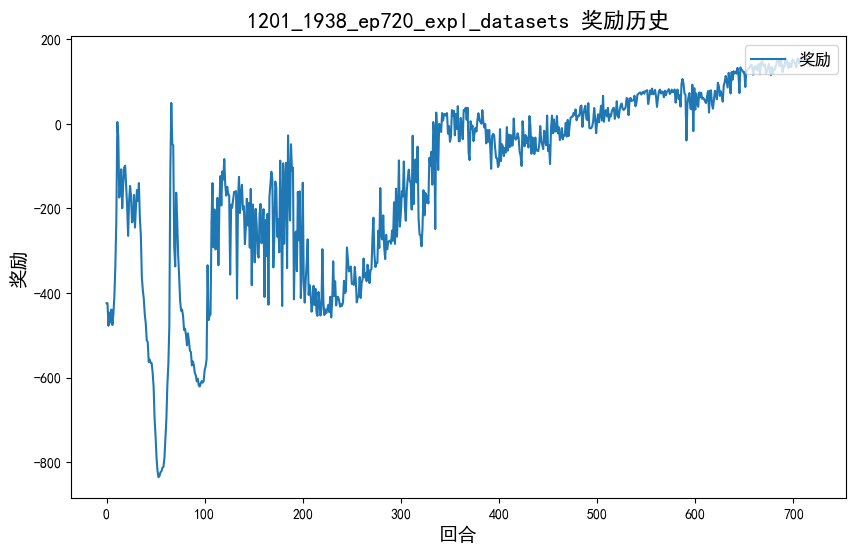

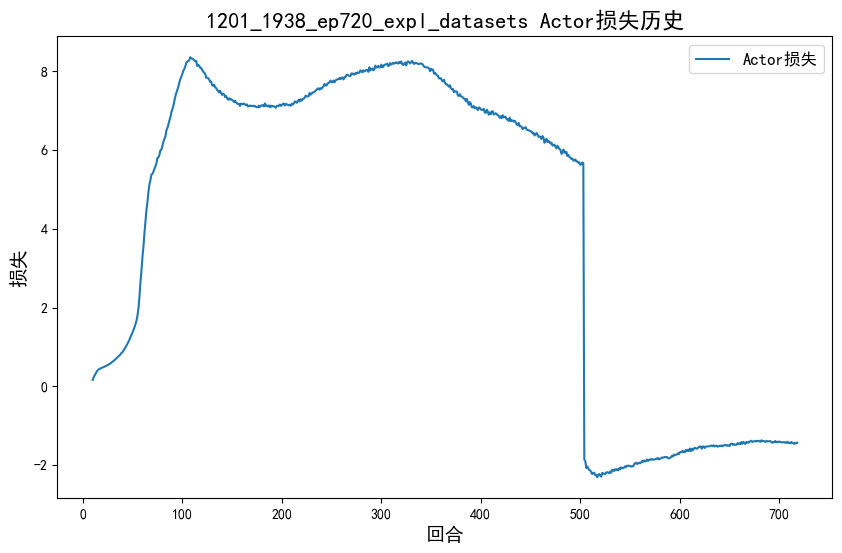

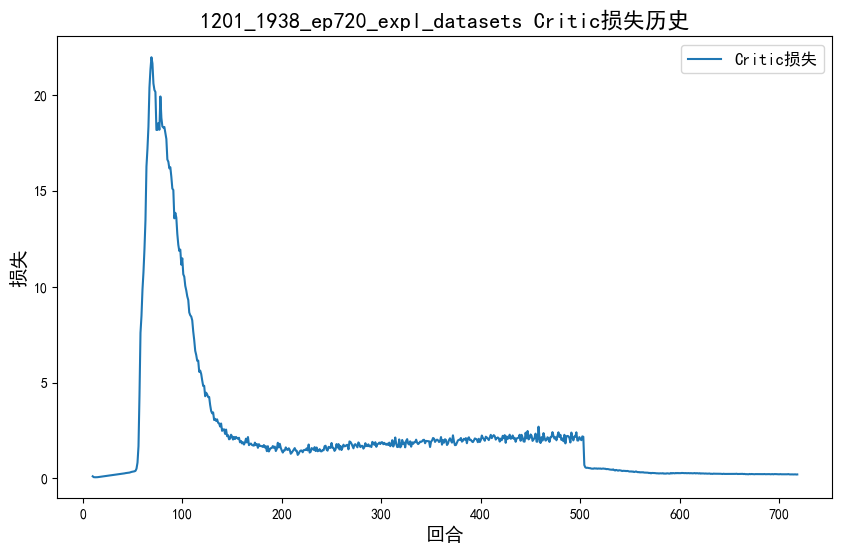

In [13]:
# 训练历程数据
train_datasets.plot_episode_datas(save_path=project_path, show=True)  # 绘制训练的奖励历程数据图
train_datasets.plot_episode_datas(plot_rewards=False, plot_actor_losses=True, plot_critic_losses=True, show=True)  # 绘制训练历程数据图

仿真进度: 100%|██████████| 1000/1000 [00:02<00:00, 365.48it/s]


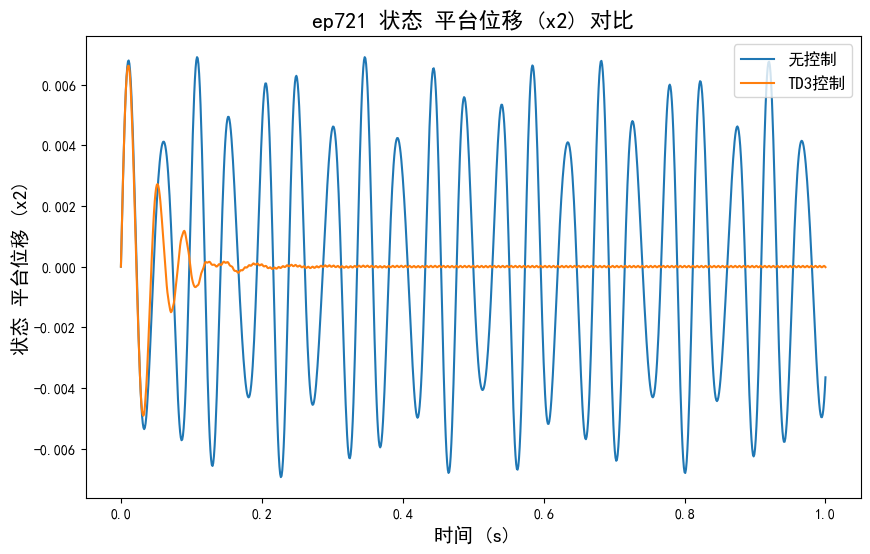

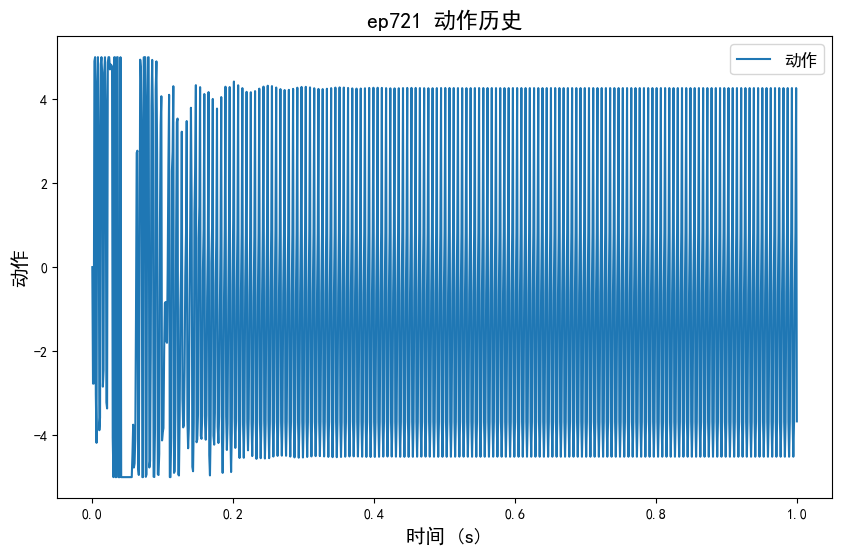

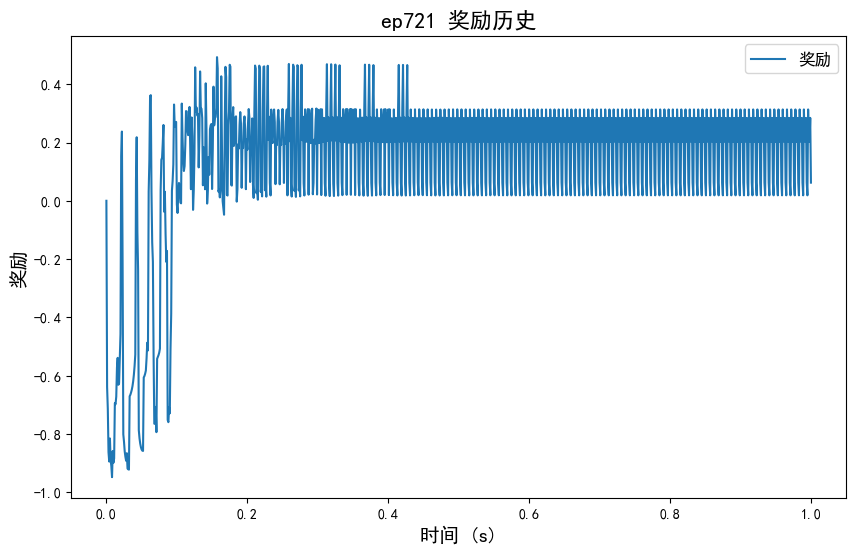

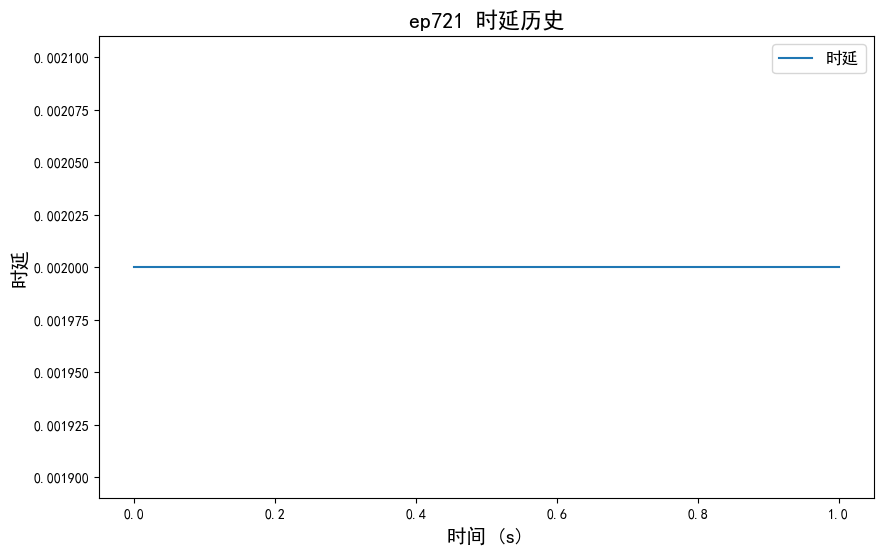

In [14]:
# 训练对比
# env.all_state0 = np.zeros(6)
env.set_disturbance(zero)
env.set_force_function(f_func=f_func)
# env.set_force_function(sin_wave(amplitude=1000, frequency=300, phase=0))  # 设置扰动函数
# env.set_force_function(sin_wave(amplitude=200, frequency=30, phase=0))  # 设置扰动函数
# env.set_force_function(sin_wave(amplitude=300, frequency=40, phase=0))  # 设置扰动函数
nc_datasets = env.run_simulation() 
c_datasets = env.run_simulation(controller=agent)
c_datasets.checkpoint_name = f"ep{train_datasets.current_episode}"
plot_compare_no_control(nc_datasets, c_datasets, plot_state=[3], save_path=save_plot_path, plot_dt=env.use_dt_noise, plot_delay_time=agent.delay_enabled, show=True)